In [12]:
#importação de pacotes and utilitarios

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import plotly.graph_objects as go
pio.renderers.default='browser'

def convertToNumber(banco, coluna):
    banco[coluna] = pd.to_numeric(banco[coluna], errors='coerce')

def calculateFatorBartlet(banco_dados, fatores):
    fa = FactorAnalyzer(n_factors=fatores, method='principal', rotation=None).fit(banco_dados)
    #%% Obtendo todos os possíveis autovalores
    autovalores = fa.get_eigenvalues()[0]
    print(autovalores)
    return fa

def buildVarianceTable(fatores):
    tabela_eigen = pd.DataFrame(fatores.get_factor_variance())
    tabela_eigen.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_eigen.columns)]
    tabela_eigen.index = ['Autovalor','Variância', 'Variância Acumulada']
    tabela_eigen = tabela_eigen.T
    return tabela_eigen

def buildFactors(fatores, banco_dados_original, banco_dados_pca, nome_variavel):
    fator = pd.DataFrame(fatores.transform(banco_dados_pca))
    fator.columns = [nome_variavel]

    # Adicionando os fatores ao banco de dados
    banco_dados_original = pd.concat([banco_dados_original.reset_index(drop=True), fator], axis=1)

    # Organizando o dataset por meio do fator
    banco_dados_original.sort_values(nome_variavel, ascending=False, inplace=True)
    banco_dados_original.reset_index(drop=True, inplace=True)

def validaPValor(valor):
    if (valor > 0.05):
        raise Exception ('P-valor com percentual elevado não iremos continuar com a analise')

SyntaxError: invalid syntax (68091771.py, line 43)

In [2]:
# importação de banco de dados
dados_pisa = pd.read_csv('./bancos_dados/notas_pisa.csv', delimiter=',')
dados_pisa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   country           96 non-null     object
 1   group             96 non-null     object
 2   mathematics_2022  96 non-null     object
 3   reading_2022      96 non-null     object
 4   science_2022      96 non-null     object
 5   mathematics_2018  96 non-null     object
 6   reading_2018      96 non-null     object
 7   science_2018      96 non-null     object
dtypes: object(8)
memory usage: 6.1+ KB


In [3]:
"""
 Em um primeiro momento só iremos utilizar as notas de 2022, 
 por este motivo será gerado outro banco de dados sem as notas de 2018
 E faremos o tratamento dos dados
"""

#remove as colunas que não usaremos
if 'mathematics_2018' in dados_pisa.columns:
    dados_pisa.drop(columns=['mathematics_2018', 'reading_2018', 'science_2018'], inplace=True)

#realizarmos padronização dos dados, pois as notas estão em formato texto, iremos transformar para numeros
convertToNumber(dados_pisa, 'mathematics_2022')
convertToNumber(dados_pisa, 'reading_2022')
convertToNumber(dados_pisa, 'science_2022')

#remove as linhas NAN
dados_pisa.dropna(inplace=True)
dados_pisa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, 0 to 95
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           81 non-null     object 
 1   group             81 non-null     object 
 2   mathematics_2022  81 non-null     float64
 3   reading_2022      81 non-null     float64
 4   science_2022      81 non-null     float64
dtypes: float64(3), object(2)
memory usage: 3.8+ KB


In [4]:
# iremos iniciar com a analise PCA

"""para gerar o mapa de calor a matriz deve possuir apenas dados categoricos, por isso iremos remover
as varveis COUNTRY E GROUP, porem agora iremos gerar outro dataFrame para manter o original e
depois fazer um merge """

pisa_pca = dados_pisa.drop(columns=['country', 'group'])

<Axes: >

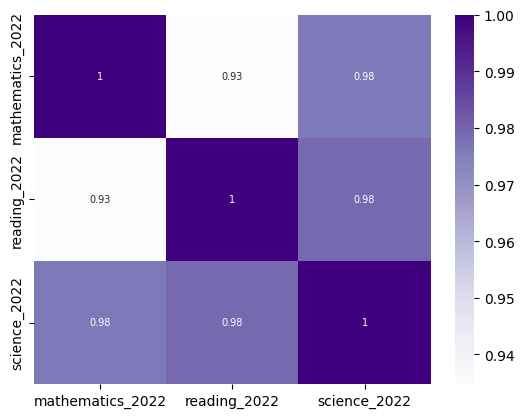

In [5]:
# Geração de mapa de calor para verificar se existe relação forte entre as variaveis
# Esta mapa é gerado apartir de uma matriz de correção, esta matriz é gerada pelo comando pisa_pca.corr()
# INTERPRETAÇÃO - no mapa de calor, quanto mais perto de 1, maior é a relação entre as variaveis
sns.heatmap(pisa_pca.corr(), annot=True, 
            cmap = plt.cm.Purples,
            annot_kws={'size':7})

In [6]:
# Realizar teste Qui quadrado, LEMBRANDO QUE CONTINUAMOS A ANALISE SE O TESTE FOR < 5%
bartlett, p_value = calculate_bartlett_sphericity(pisa_pca)
print(f'Qui² Bartlett: {round(bartlett, 2)}')
print(f'p-valor: {round(p_value, 4)}')
validaPValor(p_value)

Qui² Bartlett: 508.46
p-valor: 0.0


In [7]:
# precisamos agrupar nosso banco de dados, porem não sabemos quantos fatores devemos incluir, por isso colocamos
# a quantidade total, que é a quantidade de variaveis 3
calculateFatorBartlet(pisa_pca, 3)

# com base nos valores printados tomamos a decisão de quantos fatores precisamos, o valor ideal é 
# valores maiores que 1, NESTE CASO APENAS 1 FATOR É NECESSARIO
fatores = calculateFatorBartlet(pisa_pca, 1)

[2.92687872 0.06529156 0.00782972]
[2.92687872 0.06529156 0.00782972]


In [8]:
# agora precisamos obter % de variancia e variancia acumulada
# QUANTO MAIOR O % DE VARIANCIA MAIS DADOS TEMOS REPRESENTADOS
tabela_variancia = buildVarianceTable(fatores)
print(tabela_variancia)

# com a tabela de cargas fatorias, PASSO ABAIXO SERVE APENAS PARA ANALISE
# temos o percentual que esta sendo representado no fator em cada variavel
"""                Fator 1
mathematics_2022  0.982323
reading_2022      0.983425
science_2022      0.997394

No caso acima apenas 1 fatores representa 98% da variavel matemativa 
todas as variveis são altamente representadas """

tabela_cargas = pd.DataFrame(fatores.loadings_)
tabela_cargas.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_cargas.columns)]
tabela_cargas.index = pisa_pca.columns
print(tabela_cargas)

## Obtendo scores fatoriais
tabela_scores = pd.DataFrame(fatores.weights_)
tabela_scores.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_scores.columns)]
tabela_scores.index = pisa_pca.columns

print(tabela_scores)

# Comunidades mostram se houve perda relativa de valores dentro do fator, SERVE APENAS PARA ANALISE
# quando mais proximo de 1 MENOS INFORMAÇÃO PERDEMOS NA VARIAVEL
tabela_comunalidades = pd.DataFrame(fatores.get_communalities())
tabela_comunalidades.columns = ['Comunalidades']
tabela_comunalidades.index = pisa_pca.columns

print(tabela_comunalidades)


         Autovalor  Variância  Variância Acumulada
Fator 1   2.926879   0.975626             0.975626
                   Fator 1
mathematics_2022  0.982323
reading_2022      0.983425
science_2022      0.997394
Empty DataFrame
Columns: []
Index: [mathematics_2022, reading_2022, science_2022]
                  Comunalidades
mathematics_2022       0.964959
reading_2022           0.967125
science_2022           0.994794


In [9]:
# PASSO IMPORTANTE
# Extração dos fatores e inclusão da variavel no banco de dados original
# buildFactors(fatores, dados_pisa, pisa_pca, 'fator_2022')

fator = pd.DataFrame(fatores.transform(pisa_pca))
fator.columns = ['fator_2022']

# Adicionando os fatores ao banco de dados
dados_pisa = pd.concat([dados_pisa.reset_index(drop=True), fator], axis=1)

# Organizando o dataset por meio do fator
dados_pisa.sort_values('fator_2022', ascending=False, inplace=True)
dados_pisa.reset_index(drop=True, inplace=True)

In [10]:
## UNINDO DUAS ANALISES E REALIZANDO ANALISE DE CORRESPONDENCIA NO RESULTADO DA ANALISE DE FATORIAL ##
dados_pisa['categoria'] = pd.qcut(dados_pisa['fator_2022'], 4, labels=list(['grupo_1', 'grupo_2', 'grupo_3', 'grupo_4']))

## agora iremos verificar se possui relação dos fatoriais que viraram categorias
 # com o grupo de paises, como as duas variaveis são categoricas, iremos realiza analise de correspondencia
 
# Gerando tabela de contingencia que é o INPUT da analise de correspondencia
cross_tab = pd.crosstab(dados_pisa['categoria'], dados_pisa['group'])
print(cross_tab)

# Realizar teste para saber se possui relação os dados e se vale a pena continuar a analise
# caso p-valor seja < que 5% podemos continuar
teste_qui2 = chi2_contingency(cross_tab)
print(f"estatística qui²: {round(teste_qui2[0], 2)}")
print(f"p-valor da estatística: {round(teste_qui2[1], 4)}")
print(f"graus de liberdade: {teste_qui2[2]}")

validaPValor(teste_qui2[1])

# Gerando a tabela de contingencia para continuar a analise
tab_contingencia = sm.stats.Table(cross_tab)

# Resíduos padronizados ajustados
print(tab_contingencia.standardized_resids)

group      OECD  PARTNERS
categoria                
grupo_1       0        21
grupo_2       5        15
grupo_3      16         4
grupo_4      16         4
estatística qui²: 40.09
p-valor da estatística: 0.0
graus de liberdade: 3
group          OECD  PARTNERS
categoria                    
grupo_1   -4.736823  4.736823
grupo_2   -2.170425  2.170425
grupo_3    3.510703 -3.510703
grupo_4    3.510703 -3.510703


In [11]:
#realiza a criação do grafico

fig = go.Figure()

maxz = np.max(tab_contingencia.standardized_resids)+0.1
minz = np.min(tab_contingencia.standardized_resids)-0.1

colorscale = ['purple' if i>1.96 else '#FAF9F6' for i in np.arange(minz,maxz,0.01)]

fig.add_trace(
    go.Heatmap(
        x = tab_contingencia.standardized_resids.columns,
        y = tab_contingencia.standardized_resids.index,
        z = np.array(tab_contingencia.standardized_resids),
        text=tab_contingencia.standardized_resids.values,
        texttemplate='%{text:.2f}',
        showscale=False,
        colorscale=colorscale))

fig.update_layout(
    title='<b>Resíduos Padronizados Ajustados</b>',
    height = 600,
    width = 600)

fig.show()